# Network Analysis

This computational notebook will demonstrate how to transform Archive of Our Own fanfiction metadata for network analysis. To help with this, I used the [Program Historian's "Exploring and Analyzing Network Data with Python"](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python). [William Reed Quinn](http://williamquinn.org/) also helped with transforming the additional tags into a matrix.

What this computational notebook does is take a list of additional tags, count how often particular tags appear together, and then create a nodes/edges list based on this data. This approach can be applied to the "Additional Tags" as well as other metadata like "Character" or "Relationship." 

The goal for my network analysis is to better trace the creation and curation of fandom communities through additional tags. Which additional tags are used together? Why may this be?

In [1]:
import pandas as pd

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community
import csv

import numpy as np

import plotly.graph_objects as go

In [13]:
korra_all = pd.read_csv('./data/allkorra.csv')
korra_all.head(3)

,Unnamed: 0,work_id,title,rating,category,fandom,relationship,character,additional tags,language,...,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,0,6388009,A More Perfect Union,General Audiences,Gen,Avatar: Legend of Korra,NaN,"Noatak (Avatar), Tarrlok (Avatar), Amon (Avatar)",Alternate Universe,English,...,Updated,2018-03-14,8139,4/?,11.0,27.0,4.0,286.0,He's forgotten how to be warm. The thought wou...,2016-03
1,1,13974048,let go,Teen And Up Audiences,F/F,Avatar: Legend of Korra,Lin Beifong/Korra,"Korra (Avatar), Lin Beifong","just a quick one-shot i never posted properly,...",English,...,Completed,2018-03-14,996,1/1,NaN,NaN,NaN,41.0,"""Korra."" Somewhere distant. Someone holding h...",2018-03
2,2,13720947,Is This Your Dog?,General Audiences,F/F,Avatar: Legend of Korra,Korra/Asami Sato,"Korra (Avatar), Asami Sato, Tonraq (Avatar), M...","Alternate Universe - College/University, Alter...",English,...,Updated,2018-03-14,7585,5/?,111.0,318.0,18.0,3637.0,Korra's father kneeled down in front of her so...,2018-02


In [2]:
got0 = pd.read_csv(r'./data/got_data_clean/got0.csv')
got1 = pd.read_csv(r'./data/got_data_clean/got1.csv')
got2 = pd.read_csv(r'./data/got_data_clean/got2.csv')
got3 = pd.read_csv(r'./data/got_data_clean/got3.csv')

In [10]:
got_all = pd.concat([got0, got1, got2, got3])
got_all.head(3)

,Unnamed: 0,work_id,title,published,rating,character,relationship,additional tags,category,body,month
0,0,19289563,"game of thrones,",2019-06-20,"explicit,","arya stark, bella, gendry baratheon - characte...","gendry baratheon/arya stark, gendry baratheon/...",NaN,"multi,",authors note: this is really short but i promi...,2019-06
1,1,17179712,"game of thrones,",2018-12-27,"teen and up audiences,","jon snow | aegon targaryen, arya stark, sansa ...","jon snow/daenerys targaryen, arya stark/gendry...","armies and allies, war, romance, eventual happ...","f/m,",arya's chambers still felt different.\n\n \n\n...,2018-12
2,2,2352779,"game of thrones,",2014-09-24,"teen and up audiences,",NaN,"xander harris/spike,","established relationship, drabble,","m/m,","""it's asking again"". \n\n""then press the blood...",2014-09


## Practice!

Since this is going to be a massive file, I want to start with a small sample first to make sure my code works correctly I will use the .sample() function to grab 5 random fanfics. Then, I will lower-case all the additional tags and make each fanfics additional tag its own list. 

My new dataframe, which now has the additional tags all lower-cased and in an individual list for each code, will then be "exploded." What exploding does is take a list within a dataframe and makes each item in that list a new row, while still maintaining all the original information. 

In [6]:
practice = korra_all.sample(n=15, random_state=1).reset_index()
practice[:1]

,index,Unnamed: 0,work_id,title,rating,category,fandom,relationship,character,additional tags,...,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,6107,6107,963925,Stormchaser,General Audiences,Gen,Avatar: Legend of Korra,Bolin & Mako (Avatar),"Mako, Bolin, Lightning Bolt Zolt","Brothers, Family, Angst, Hurt/Comfort, Kid Fic...",...,Completed,2013-09-12,2083,1/1,1.0,90.0,5.0,1165.0,Mako watched the firebenders from the abandone...,2013-09


In [7]:
practice["additional tags"]= practice["additional tags"].str.lower().str.split(",")
practice[:1]

,index,Unnamed: 0,work_id,title,rating,category,fandom,relationship,character,additional tags,...,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,6107,6107,963925,Stormchaser,General Audiences,Gen,Avatar: Legend of Korra,Bolin & Mako (Avatar),"Mako, Bolin, Lightning Bolt Zolt","[brothers, family, angst, hurt/comfort, ki...",...,Completed,2013-09-12,2083,1/1,1.0,90.0,5.0,1165.0,Mako watched the firebenders from the abandone...,2013-09


In [8]:
practice = practice.drop(columns = ["index","Unnamed: 0"])
practice[:1]

,work_id,title,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,963925,Stormchaser,General Audiences,Gen,Avatar: Legend of Korra,Bolin & Mako (Avatar),"Mako, Bolin, Lightning Bolt Zolt","[brothers, family, angst, hurt/comfort, ki...",English,2013-09-12,Completed,2013-09-12,2083,1/1,1.0,90.0,5.0,1165.0,Mako watched the firebenders from the abandone...,2013-09


In [9]:
practice = practice[['additional tags', 'work_id']]
practiceNewdf = practice.explode('additional tags')
practiceNewdf[:1]

,additional tags,work_id
0,brothers,963925


### NewDF: exploding and creating matrix

Now that I have used the "explode()" function above to create a dataframe where each additional tag has its own row and still has the work_id as a unique ID, I will now add a "count" column that just adds one number, which I can then use to transform into a longer dataframe. 

In [10]:
practiceNewdf["count"] = practiceNewdf.groupby(["work_id","additional tags"])["additional tags"].transform("count").fillna(0).astype(int)
practiceNewdf[:1]

,additional tags,work_id,count
0,brothers,963925,1


After creating a dataframe that has three columns (additional tags, work_id, and count), I will use the "pivot" function to take this data frame and make it wider. I'm not 100% sure how to explain pivot, but as you see in the dataframe below, the new index is the "work_id" and the new dataframe counts how often a particular additional tag appears in that index.

I probably do not need to keep the work_id, but I think it is better to be safe than sorry.

The function "df.columns.name = None" removes any weird metadata that names all the columns "additional tags." One issue I was facing is my matrix (see below) was not being properly made into an edges list because the columns were being labeled as "additional tags" and throwing everything off. 

Finally, the function "df.columns.fillna('none')" replaces the Nan (blank) column name with the name "none." Then, I deleted the "none" column. This way, I don't have any blank tags, and they're not important anyway!

In [11]:
practiceWorkID = practiceNewdf.pivot(index="work_id", columns="additional tags", values="count").fillna(0)

#removing column metadata
practiceWorkID.columns.name = None

#renaming "Nan" into "none" so it actually appears instead of being a null value
practiceWorkID.columns = practiceWorkID.columns.fillna('none')
practiceWorkID = practiceWorkID.drop(columns = 'none')

practiceWorkID

,airbending & airbenders,alternate universe - canon divergence,angst,avatar state,bending (avatar),canon compliant,canon divergence - the ultimatum,car sex is awkward,cutipies,drama,...,brothers,crack,drift partner au,friends to lovers,makorra week,originally posted on fanfiction.net,references to canon typical violence,romance,silliness,violence
work_id,,,,,,,,,,,,,,,,,,,,,
963925,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1055470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1285312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2819411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3377765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3676986,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4015582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4315212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
adj_matrix = practiceWorkID.T.dot(practiceWorkID).astype(int)
adj_matrix

,airbending & airbenders,alternate universe - canon divergence,angst,avatar state,bending (avatar),canon compliant,canon divergence - the ultimatum,car sex is awkward,cutipies,drama,...,brothers,crack,drift partner au,friends to lovers,makorra week,originally posted on fanfiction.net,references to canon typical violence,romance,silliness,violence
airbending & airbenders,1,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
alternate universe - canon divergence,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
angst,0,0,3,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
avatar state,1,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
bending (avatar),1,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
canon compliant,1,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
canon divergence - the ultimatum,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
car sex is awkward,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
cutipies,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
drama,1,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### Practice: Matrix > Edges & Nodes List

In this final section, I will create both the edges and nodes csv files.

To create the edges list, I used the function "stack" on the matrix I created above and the reset_index function. The edges will now have three columns: the additional tag, another additonal tag, and the weight of its relationship. I also renamed all the columns.

To create the nodes list, 

In [13]:
#using .stack() and .reset(index)
practice_edges_list = adj_matrix.stack().reset_index()

#renaming columns for clarity purposes
practice_edges_list = practice_edges_list.rename({'level_0':'source', 'level_1': 'target', 0:'weight'}, axis='columns')

#yay looks good!
practice_edges_list[:2]

,source,target,weight
0,airbending & airbenders,airbending & airbenders,1
1,airbending & airbenders,alternate universe - canon divergence,0


In [14]:
# nodes list: adj_matrix['additional tags'].unique
practice_nodes_list = practiceNewdf['additional tags'].drop_duplicates().reset_index()
practice_nodes_list = practice_nodes_list.drop(columns="index")
practice_nodes_list[:2]

,additional tags
0,brothers
1,family


In [15]:
practice_edges_list.to_csv('./data/practice_edges.csv', index=False)

In [16]:
practice_nodes_list.to_csv('./data/practice_nodes.csv', index=False)

### Creating A Network Graph!

Code taken from Programming Historian!

In [17]:
with open('./data/practice_nodes.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

# Get a list of just the node names (the first item in each row)
node_names = [n[0] for n in nodes]

# Read in the edgelist file
with open('./data/practice_edges.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:]

# Print the number of nodes and edges in our two lists
print(len(node_names))
print(len(edges))

G = nx.Graph() # Initialize a Graph object
G.add_nodes_from(node_names) # Add nodes to the Graph
G.add_weighted_edges_from(edges) # Add edges to the Graph
print(nx.info(G)) # Print information about the Graph

58
3249
Name: 
Type: Graph
Number of nodes: 58
Number of edges: 1653
Average degree:  57.0000


In [18]:
density = nx.density(G)
print("Network density:", density)

Network density: 1.0


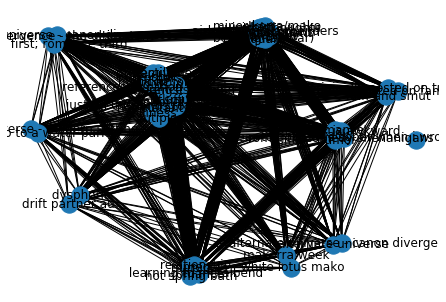

In [19]:
nx.draw(G, with_labels = True) 

## Full Throttle!

Let's try with the full corpus! I am following the exact same steps I have above, except I am doing the <em>entire</em> corpus!

Before I save the corpus, I will also choose only those with a weight of 20 or above. This means two additional tags that appear together more than 20 times, as this is a better determiner of larger community practices.

### Prepping the Data
Below, I go through the Korra & GOT datasets to make everything lowercase and put each additional tag into a string. I'm going to merge TLOK and GOT datasets so I only have to run these on one dataset.

In [24]:
korra_all["additional tags"]= korra_all["additional tags"].str.lower().str.split(",")
korra_all[:1]

,Unnamed: 0,work_id,title,rating,category,fandom,relationship,character,additional tags,language,...,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,0,6388009,A More Perfect Union,General Audiences,Gen,Avatar: Legend of Korra,NaN,"Noatak (Avatar), Tarrlok (Avatar), Amon (Avatar)",[alternate universe],English,...,Updated,2018-03-14,8139,4/?,11.0,27.0,4.0,286.0,He's forgotten how to be warm. The thought wou...,2016-03


In [25]:
korra_all = korra_all.drop(columns = ["Unnamed: 0"])
korra_all[:1]

,work_id,title,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,chapters,comments,kudos,bookmarks,hits,body,month
0,6388009,A More Perfect Union,General Audiences,Gen,Avatar: Legend of Korra,NaN,"Noatak (Avatar), Tarrlok (Avatar), Amon (Avatar)",[alternate universe],English,2016-03-28,Updated,2018-03-14,8139,4/?,11.0,27.0,4.0,286.0,He's forgotten how to be warm. The thought wou...,2016-03


In [28]:
korra_all = korra_all[['additional tags', 'work_id']]
korraDFexploded = korra_all.explode('additional tags')
korraDFexploded[:5]

,additional tags,work_id
0,alternate universe,6388009
1,just a quick one-shot i never posted properly,13974048
1,angst,13974048
1,post-season/series 03,13974048
1,post-break up,13974048


In [29]:
korraDFexploded["count"] = korraDFexploded.groupby(["work_id","additional tags"])["additional tags"].transform("count").fillna(0).astype(int)
korraDFexploded[:2]

,additional tags,work_id,count
0,alternate universe,6388009,1
1,just a quick one-shot i never posted properly,13974048,1


In [30]:
korraWorkID = korraDFexploded.pivot(index="work_id", columns="additional tags", values="count").fillna(0)

#removing column metadata
korraWorkID.columns.name = None

#renaming "Nan" into "none" so it actually appears instead of being a null value
korraWorkID.columns = korraWorkID.columns.fillna('none')
korraWorkID = korraWorkID.drop(columns = 'none')

korraWorkID

,"""shut-up kiss"" cliche",#weallgotissues,&gt;.&gt;,(also of course),(at least i think it is anyway),(at least... getting there),(but just barely),(except the comics),(honestly this is barely anything and arguably not worth reading),(if that),...,zhurrick is my life,zombie au,zombie lemurs,zuki,zuko babysits,zuko gives advice,zuko is rubbish at crafts,zuko's dragon - freeform,zutara,zutara week
work_id,,,,,,,,,,,,,,,,,,,,,
165877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
239723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13935243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13954347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13955325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
korraMatrix = korraWorkID.T.dot(korraWorkID).astype(int)
korraMatrix

,"""shut-up kiss"" cliche",#weallgotissues,&gt;.&gt;,(also of course),(at least i think it is anyway),(at least... getting there),(but just barely),(except the comics),(honestly this is barely anything and arguably not worth reading),(if that),...,zhurrick is my life,zombie au,zombie lemurs,zuki,zuko babysits,zuko gives advice,zuko is rubbish at crafts,zuko's dragon - freeform,zutara,zutara week
"""shut-up kiss"" cliche",1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#weallgotissues,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
&gt;.&gt;,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(also of course),0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(at least i think it is anyway),0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuko gives advice,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
zuko is rubbish at crafts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
zuko's dragon - freeform,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
zutara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
#using .stack() and .reset(index)
korra_edges = korraMatrix.stack().reset_index()

#renaming columns for clarity purposes
korra_edges = korra_edges.rename({'level_0':'source', 'level_1': 'target', 0:'weight'}, axis='columns')

#yay looks good!
korra_edges[:2]

,source,target,weight
0,"""shut-up kiss"" cliche","""shut-up kiss"" cliche",1
1,"""shut-up kiss"" cliche",#weallgotissues,0


In [33]:
#The "Weight" >= 20 means the tags must appear at least 10 times to be incorporated. 
#Also, the "query" makes sure to remove any duplicate sources/targets

korra_edges15 = korra_edges[ (korra_edges['weight'] >= 10)]
korra_edges15 = korra_edges15.query("source != target")
korra_edges15

,source,target,weight
1740378,action,romance,10
1773717,action/adventure,romance,18
1995977,adventure,romance,12
2647318,airbending & airbenders,earthbending & earthbenders,16
2647749,airbending & airbenders,firebending & firebenders,17
...,...,...,...
117634666,romance,hurt/comfort,15
117638299,romance,smut,12
118989817,smut,fluff and smut,12
118992725,smut,oral sex,11


In [34]:
# nodes list: adj_matrix['additional tags'].unique
korra_nodes = korra_edges15['source'].drop_duplicates().reset_index()
korra_nodes = korra_nodes.drop(columns="index")
korra_nodes[:2]

,source
0,action
1,action/adventure


In [35]:
korra_edges15.to_csv('./data/korra_edges.csv', index=False)
korra_nodes.to_csv('./data/korra_nodes.csv', index=False)

In [36]:
with open('./data/korra_nodes.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

# Get a list of just the node names (the first item in each row)
node_names = [n[0] for n in nodes]

# Read in the edgelist file
with open('./data/korra_edges.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:]

# Print the number of nodes and edges in our two lists
print(len(node_names))
print(len(edges))

G = nx.Graph() # Initialize a Graph object
G.add_nodes_from(node_names) # Add nodes to the Graph
G.add_weighted_edges_from(edges) # Add edges to the Graph
print(nx.info(G)) # Print information about the Graph

113
516
Name: 
Type: Graph
Number of nodes: 113
Number of edges: 258
Average degree:   4.5664


In [37]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.04077117572692794


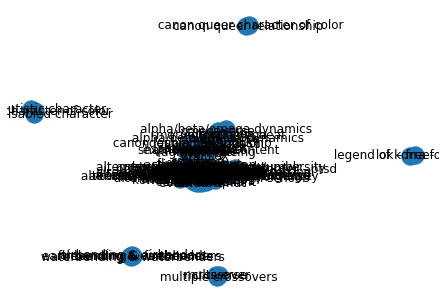

In [38]:
nx.draw(G, with_labels = True) 

In [39]:
nx.write_gexf(G, './data/korra_network.gexf')

## Creating a Visualization

I created the visualization by first reading in my nodes and edges files using the Program Historian's code. Then, I used [Plotly's network graph documentation](https://plotly.com/ipython-notebooks/network-graphs/) to create the graph.

The main line of code I added is three cells below creating a "pos" (positions) column that Plotly can then use to map onto the graph. Positon means the literal x,y position of a node. NetworkX has different layouts to choose from for positioning your nodes.

In [40]:
with open('./data/korra_nodes.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

# Get a list of just the node names (the first item in each row)
node_names = [n[0] for n in nodes]

# Read in the edgelist file
with open('./data/korra_edges.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:]

In [41]:
print(len(node_names))
print(len(edges))

G = nx.Graph() # Initialize a Graph object
G.add_nodes_from(node_names) # Add nodes to the Graph
G.add_weighted_edges_from(edges) # Add edges to the Graph
print(nx.info(G)) # Print information about the Graph

113
516
Name: 
Type: Graph
Number of nodes: 113
Number of edges: 258
Average degree:   4.5664


In [62]:
# Adding positions in my data

pos = nx.spring_layout(G, k=0.6, iterations=60)
for n,p in pos.items():
    G.nodes[n]['pos'] = p


In [63]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.9, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_label =[]
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_label.append(node)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    text= node_label, textposition='top center',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='purd',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=20,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [64]:
node_adjacencies = []
# node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('Tag:' +str(node))

node_trace.marker.color = node_adjacencies
# node_trace.text = node_text

In [65]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
#                 title='The Legend of Korra Fanfiction Additional Tags',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

fig.write_html("./models/network_graph_korra.html")